In [1]:
#include <TChain.h>
#include <vector>
#include <TFile.h>
#include <iostream>
#include <string>
#include <stdio.h>

In [2]:
//float lumi = 0.5;
//float lumi = 1.9 # fb-1 # data_B only
//float lumi = 2.9 # fb-1 # data_C only
//float lumi = 4.7 # fb-1 # data_D only
float lumi = 10; // fb-1 // data_A,data_B,data_C,data_D

float fraction = 1.0; // reduce this is you want the code to run quicker

//TString path = "Input/GamGam/Data/" // local 
TString path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/" // web address

(TString &) "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/"[75]


In [3]:
TChain *data_chain = new TChain("mini");
data_chain->AddFile(path + "data_A.GamGam.root");
data_chain->AddFile(path + "data_B.GamGam.root");
data_chain->AddFile(path + "data_C.GamGam.root");
data_chain->AddFile(path + "data_D.GamGam.root");
int nentries = data_chain->GetEntries();
cout << nentries << endl;

7798424


In [4]:
vector<float>   *photon_pt;
vector<float>   *photon_eta;
vector<float>   *photon_phi;
vector<float>   *photon_E;
vector<bool>    *photon_isTightID;
vector<float>   *photon_etcone20;

data_chain->SetBranchAddress("photon_pt", &photon_pt);
data_chain->SetBranchAddress("photon_eta", &photon_eta);
data_chain->SetBranchAddress("photon_phi", &photon_phi);
data_chain->SetBranchAddress("photon_E", &photon_E);
data_chain->SetBranchAddress("photon_isTightID", &photon_isTightID);
data_chain->SetBranchAddress("photon_etcone20", &photon_etcone20);

In [5]:
TCanvas *canvas = new TCanvas();
TH1F *hist = new TH1F("Hyy_invmass", "Diphoton invariant mass ; Invariant Mass m_{yy} [GeV] ; Events",30,100,160);
TGraphErrors *graph = new TGraphErrors(); 

In [6]:
bool implemented_cuts(vector<bool> photon_isTightID, vector<float> photon_pt, vector<float> photon_etcone20, 
                       vector<float> photon_eta)
{
    bool good_event = false;
    bool TightID = false;   
    bool Pt = false;
    bool Etcone20 = false;
    bool Eta = false;
    
    // Cut on photon reconstruction quality
    if((photon_isTightID[0]==true) && (photon_isTightID[1]==true))
    {
        TightID = true;
    }
    
    // Cut on Transverse momentum, want to keep events where photon_pt[0]>40000 MeV and photon_pt[1]>30000 MeV
    if((photon_pt[0]>40000) && (photon_pt[1]>30000))
    {
        Pt = true;
    }
    
    // Cut on energy isolation, Photon candidates are required to have an isolation transverse energy of less than 4 GeV
    if((photon_etcone20[0]<4000) && (photon_etcone20[1]<4000))
    {
        Etcone20 = true;
    }
    
    // Cut on pseudorapidity in barrel/end-cap transition region, excluding the 
    // calorimeter barrel/end-cap transition region 1.37 < |η| < 1.52
    if( ((TMath::Abs(photon_eta[0])>1.52) || (TMath::Abs(photon_eta[0])<1.37)) 
       && ((TMath::Abs(photon_eta[1])>1.52) || (TMath::Abs(photon_eta[1]))) )
    {
        Eta = true;
    }
    
    if (TightID==true && Pt==true && Etcone20==true && Eta==true)
    {
        good_event = true;
    }
    
    return good_event;
}

In [7]:
float calc_myy_in_GeV(vector<float> photon_pt, vector<float> photon_eta, vector<float> photon_phi, vector<float> photon_E)
{
    float sumE = 0, px_0 = 0, px_1 = 0, py_0 = 0, py_1 = 0, pz_0 = 0, pz_1 = 0; 
    
    sumE = photon_E[0] + photon_E[1];
    
    px_0 = photon_pt[0]*TMath::Cos(photon_phi[0]); // x-momentum of 0th photon
    px_1 = photon_pt[1]*TMath::Cos(photon_phi[1]); // x-momentum of 1st photon
    py_0 = photon_pt[0]*TMath::Sin(photon_phi[0]); // y-momentum of 0th photon
    py_1 = photon_pt[1]*TMath::Sin(photon_phi[1]); // y-momentum of 1st photon
    pz_0 = photon_pt[0]*TMath::SinH(photon_eta[0]); // z-momentum of 0th photon
    pz_1 = photon_pt[1]*TMath::SinH(photon_eta[1]); // z-momentum of 1st photon
    
    float sumpx = 0, sumpy = 0, sumpz = 0, sump = 0;
    
    sumpx = px_0 + px_1; // sumpx = sum of x-momenta
    sumpy = py_0 + py_1; // sumpy = sum of y-momenta
    sumpz = pz_0 + pz_1; // sumpz = pz_0 + pz_1
    sump = TMath::Sqrt(sumpx*sumpx + sumpy*sumpy + sumpz*sumpz); //sump = magnitude of total momentum vector. 
    float Myy = TMath::Sqrt(sumE*sumE - sump*sump)/1000.0; //divide by 1000 to go from MeV to GeV
    
    return Myy;
}

In [8]:
void get_data_from_files(TString filename)
{
    TFile *output = new TFile(filename+".root", "recreate");
    TTree *tree = new TTree("tree", "tree");
    
    vector<float>   *p_pt, *p_eta, *p_phi, *p_E, *p_etcone20;
    vector<bool> *p_isTightID;
    
    tree->Branch("photon_pt", &p_pt, "p_pt/F");
    tree->Branch("photon_eta", &p_eta, "p_eta/F");
    tree->Branch("photon_phi", &p_phi, "p_phi/F");
    tree->Branch("photon_E", &p_E, "p_E/F");
    tree->Branch("photon_etcone20", &p_etcone20, "p_etcone20/F");
    tree->Branch("photon_isTightID", &p_isTightID, "p_isTightID/B");
    int nestimate = 0;
    for(int ii=0; ii<nentries; ii++)
    {
        data_chain->GetEntry(ii);
        if (implemented_cuts(*photon_isTightID, *photon_pt, *photon_etcone20, *photon_eta)==true)
        {
            p_pt = photon_pt;
            p_eta = photon_eta;
            p_phi = photon_phi;
            p_E = photon_E;
            p_etcone20 = photon_etcone20;
            p_isTightID = photon_isTightID;
            tree->Fill();
            
            //float Myy = calc_myy_in_GeV(*photon_pt, *photon_eta, *photon_phi, *photon_E);
            float Myy = calc_myy_in_GeV(*p_pt, *p_eta, *p_phi, *p_E);
            hist->Fill(Myy);
            nestimate += 1;
            //cout << photon_pt->at(0) << "\t" << photon_E->at(0) << "\t" << photon_pt->at(1) << "\t" << photon_E->at(1) << endl;
        }
    }
    output->Write();
    output->Close();
    cout << "n events selected: \t" << nestimate << endl;
}

In [9]:
TString filename = "Selected_events_Hyy_information";
get_data_from_files(filename);

n events selected: 	398313


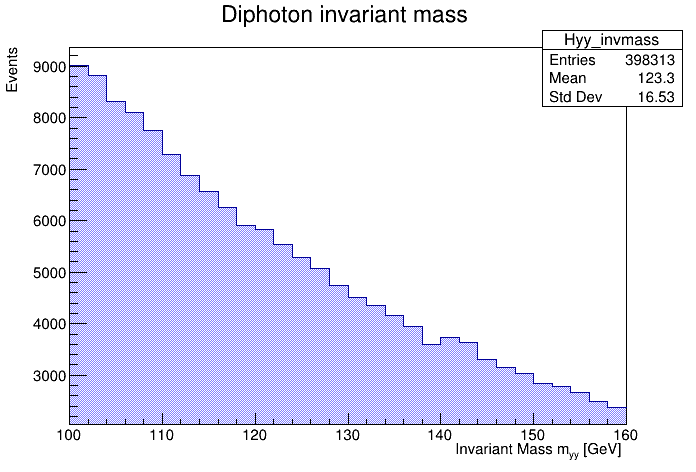

In [10]:
hist->SetFillColorAlpha(kBlue, 0.5);
hist->SetFillStyle(3001);

TStyle *atlasStyle = new TStyle("ATLAS","Atlas style");
Int_t icol=0; // WHITE
atlasStyle->SetFrameBorderMode(icol);
atlasStyle->SetFrameFillColor(icol);
atlasStyle->SetCanvasBorderMode(icol);
atlasStyle->SetCanvasColor(icol);
atlasStyle->SetPadBorderMode(icol);
atlasStyle->SetPadColor(icol);
atlasStyle->SetStatColor(icol);
atlasStyle->SetPaperSize(20,26);
atlasStyle->SetPadTopMargin(0.05);
atlasStyle->SetPadRightMargin(0.05); 
atlasStyle->SetPadBottomMargin(0.16);
atlasStyle->SetPadLeftMargin(0.16); 
atlasStyle->SetTitleXOffset(1.4);
atlasStyle->SetTitleYOffset(1.4);
Int_t font=42; // Helvetica
Double_t tsize=0.05;
atlasStyle->SetTextFont(font);
atlasStyle->SetTextSize(tsize);
atlasStyle->SetLabelFont(font,"x");
atlasStyle->SetTitleFont(font,"x");
atlasStyle->SetLabelFont(font,"y");
atlasStyle->SetTitleFont(font,"y");
atlasStyle->SetLabelFont(font,"z");
atlasStyle->SetTitleFont(font,"z");
atlasStyle->SetLabelSize(tsize,"x");
atlasStyle->SetTitleSize(tsize,"x");
atlasStyle->SetLabelSize(tsize,"y");
atlasStyle->SetTitleSize(tsize,"y");
atlasStyle->SetLabelSize(tsize,"z");
atlasStyle->SetTitleSize(tsize,"z");
atlasStyle->SetMarkerStyle(20);
atlasStyle->SetMarkerSize(1.2);
atlasStyle->SetHistLineWidth(2.);
atlasStyle->SetLineStyleString(2,"[12 12]"); // postscript dashes
atlasStyle->SetEndErrorSize(0.);
atlasStyle->SetOptTitle(0);
atlasStyle->SetOptStat(0);
atlasStyle->SetOptFit(0);
atlasStyle->SetPadTickX(1);
atlasStyle->SetPadTickY(1);

TLatex l;
l.SetNDC();
l.SetTextFont(42);
l.SetTextColor(kBlack);
l.SetTextSize(0.045);  
l.DrawLatex(0.50,0.6,"ATLAS work in progress");

TLatex o;
o.SetNDC();
o.SetTextFont(42);
o.SetTextColor(kBlack);
o.SetTextSize(0.03);
double dely = 0.04; 
o.DrawLatex(0.50,0.6-dely, Form("#sqrt{s} = 13 TeV"));
o.DrawLatex(0.50,0.57-dely, Form("H #rightarrow #gamma #gamma"));

hist->Draw();
canvas->Draw();

In [11]:
/*
TFile *selected_data = TFile::Open("Selected_events_Hyy_information.root", "read");
TH1F *hist2 = new TH1F("Hyy_invmass","H to yy ; Invariant Mass m_{yy} [GeV] ; Events",160,0,160);
TTree *selected_t = (TTree*) selected_data->Get("tree");
int nentries_2 = selected_t->GetEntries();
cout << nentries_2 << endl; 
for (int ii=0; ii<nentries_2; ii++)
{
    selected_t->GetEntry(ii);
    float Myy2 = calc_myy_in_GeV(*photon_pt, *photon_eta, *photon_phi, *photon_E);
    cout << photon_pt->at(0) << "\t" << photon_E->at(0) << "\t" << photon_pt->at(1) << "\t" << photon_E->at(1) << endl;
    hist2->Fill(Myy2);
}
hist2->Draw();
canvas->Draw();
*/

In [12]:
/*
float x = 101.0; // x center of the first bin
int npoint = 1; // First point of the graph
while (x < 160) // 110 is the maximum value of the X axis
{
    int bin = hist->FindBin(x); //Find the bin in which x should be
    float y = hist->GetBinContent(bin); //Give the number of events in the bin determined by the x value
    // statistical error on the data
    float ex = 0.0; // No error on x values
    float ey = TMath::Sqrt(y);
    graph->SetPoint(npoint, x, y);
    //graph->SetPointError(npoint, ex, ey); // No errors in x values, only in the y values.
    x += 1; // x values go between the middle point of each bin until reach the last one (159)
    //cout << x << "\t" << y << endl;
    npoint += 1;
}
// fits
TF1 *polinomic_fit = new TF1("polinomic fit", "pol4", 100, 160);
TF1 *gaussian_fit = new TF1("gaussian fit", "gaus", 100, 160);

//Set Parameters
polinomic_fit->SetParameter(0, 500);
polinomic_fit->SetParameter(1, 0);
polinomic_fit->SetParameter(2, 0);
polinomic_fit->SetParameter(3, 0);
polinomic_fit->SetParameter(4, 0);

gaussian_fit->SetParameter(1, 125);
gaussian_fit->SetParameter(2, 5);

// Title graph
graph->SetTitle("M to yy");

// x-axis label
graph->GetXaxis()->SetTitle("M_{yy} [GeV]");

// y-axis label
graph->GetYaxis()->SetTitle("Events");

// x-axis range
//graph->GetXaxis()->SetRangeUser(30, 115);

// y-axis range
//graph->SetMinimum(0);

//graph->SetMarkerSize(1);

//graph->Draw("AP");
//canvas->SetLogy();

// x-axis range
graph->GetXaxis()->SetLimits(100, 160);

// y-axis range
graph->SetMinimum(100);
graph->SetMarkerStyle(20);
graph->SetMarkerSize(1);
graph->Draw("AP");
graph->Fit("polinomic fit", "R");
graph->Fit("gaussian fit", "R");
canvas->Draw();
*/